In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

In [1]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 47

print(mat_files[idx])

Flash_transm_50Hz_5J_Tamb_2_PA.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [5]:
image_sequence.shape

(345, 640, 2526)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


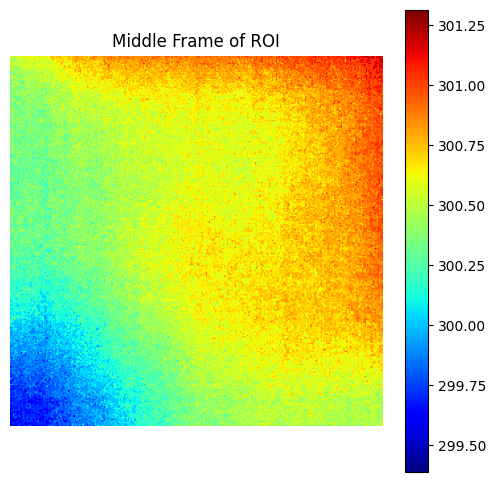

In [6]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

In [7]:
print(y, y + h_roi, x, x + w_roi, sep=", ")

13, 294, 185, 467


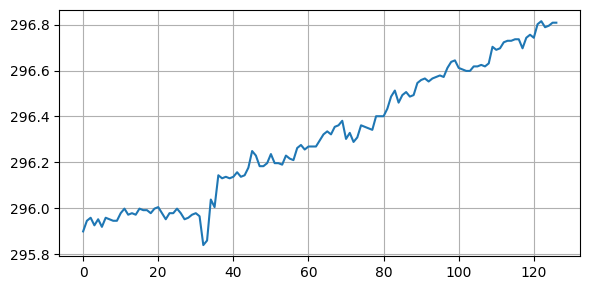

206


In [14]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 110

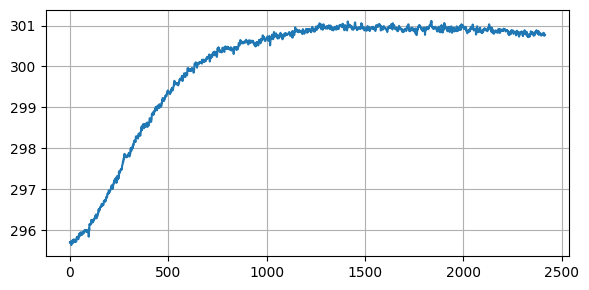

In [15]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()

        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')

        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)

        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)

        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )


    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)

        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [19]:
import torch.nn.functional as F

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 2.0699 | Recon = 1.9975 | Z = 0.0724
Epoch 10: Total Loss = 0.0157 | Recon = 0.0094 | Z = 0.0063
Epoch 20: Total Loss = 0.0078 | Recon = 0.0056 | Z = 0.0022
Epoch 30: Total Loss = 0.0039 | Recon = 0.0031 | Z = 0.0007
Epoch 40: Total Loss = 0.0038 | Recon = 0.0028 | Z = 0.0010
Epoch 50: Total Loss = 0.0031 | Recon = 0.0026 | Z = 0.0005
Epoch 60: Total Loss = 0.0032 | Recon = 0.0028 | Z = 0.0004
Epoch 70: Total Loss = 0.0030 | Recon = 0.0026 | Z = 0.0003
Epoch 80: Total Loss = 0.0031 | Recon = 0.0028 | Z = 0.0003
Epoch 90: Total Loss = 0.0030 | Recon = 0.0026 | Z = 0.0003
Epoch 100: Total Loss = 0.0025 | Recon = 0.0023 | Z = 0.0002


In [20]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())

principal_comp = torch.cat(all_latents, dim=0).numpy()

In [21]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

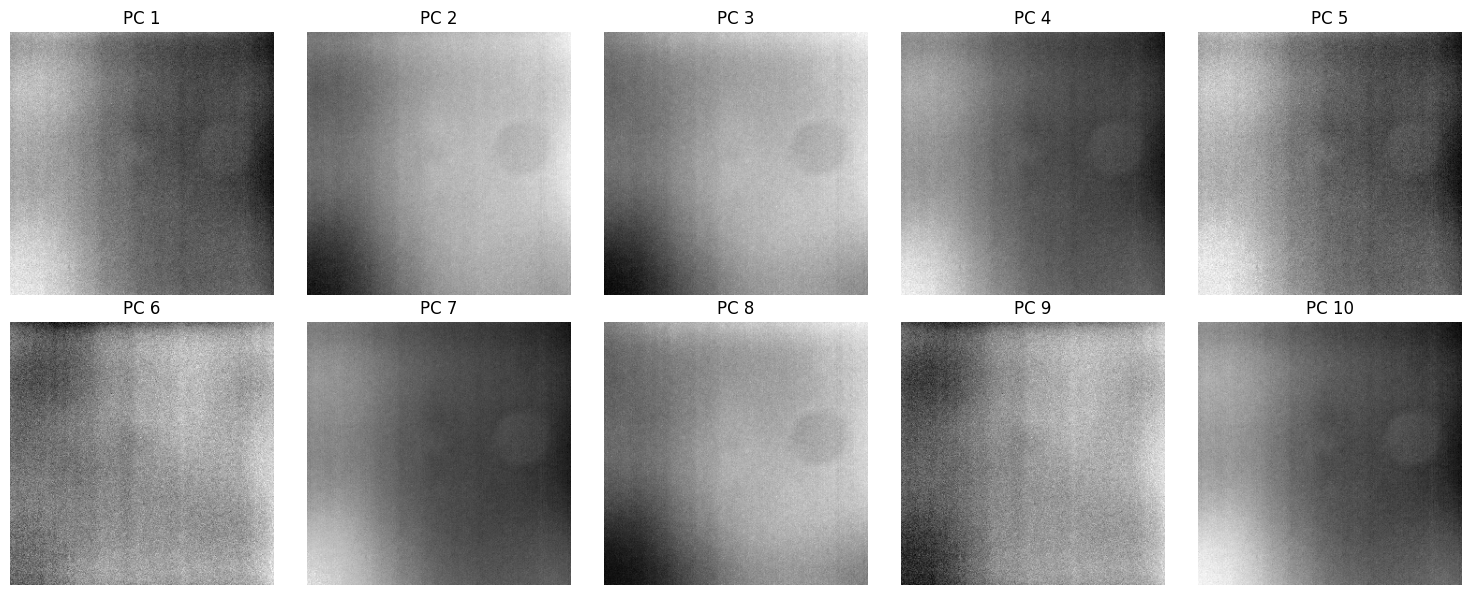

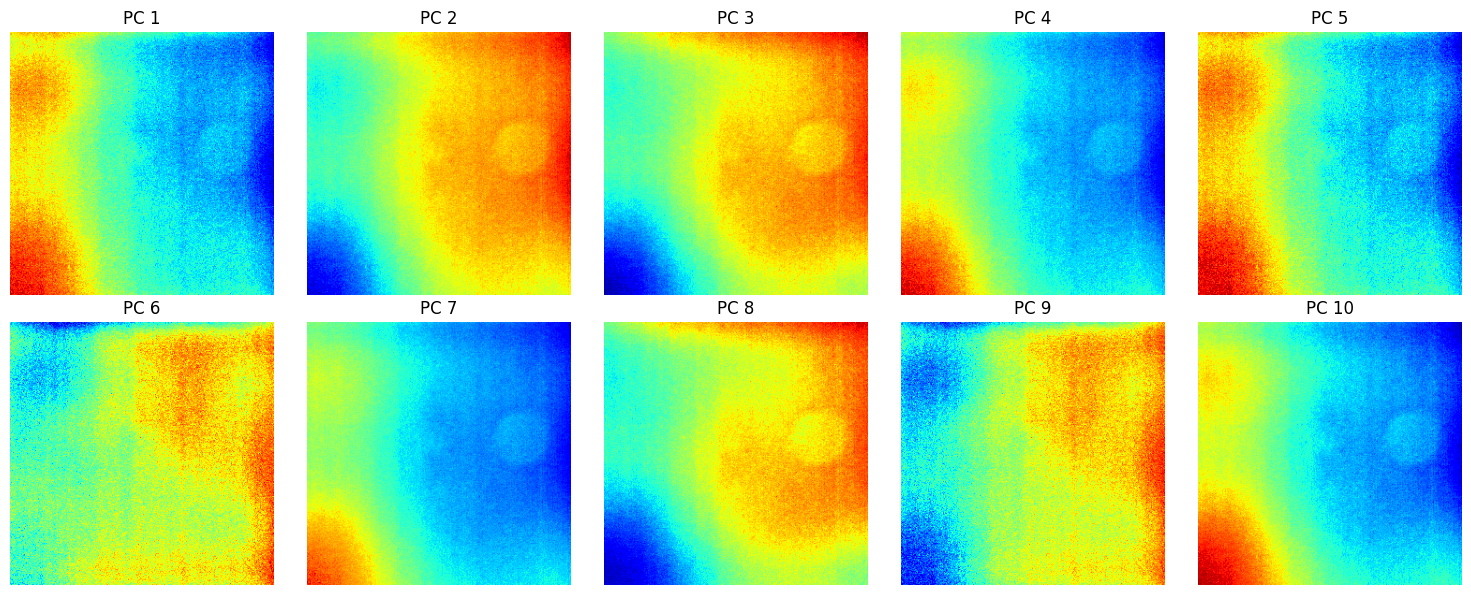

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

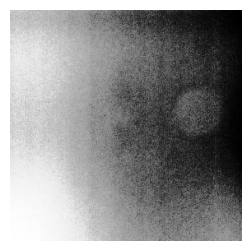

In [ ]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

# pca = PCA(n_components=1)
# pca_result = pca.fit_transform(flat)
# comp = pca_result.reshape(H, W)

comp = np.mean(pca_array, axis=0)

p1 = np.percentile(comp, 1)
p99 = np.percentile(comp, 99)
comp = np.clip(comp, p1, p99)
comp = (comp - p1) / (p99 - p1 + 1e-8)
comp = (comp * 255).astype(np.uint8)

bgr = cv2.applyColorMap(comp, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(comp, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# import torch
# import cv2
# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# C, H, W = pca_array.shape
# flat = pca_array.reshape(C, -1).T

# pca = PCA(n_components=1)
# pca_result = pca.fit_transform(flat)
# comp = pca_result.reshape(H, W)

# # comp = np.mean(pca_array, axis=0)

# comp -= comp.min()
# comp /= comp.max()
# comp = (comp * 255).astype(np.uint8)

# gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# gray_8u = cv2.equalizeHist(comp)
# bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
# img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

# plt.figure(figsize=(3, 3))
# plt.imshow(img_rgb, cmap='gray')
# plt.axis('off')
# plt.show()

In [24]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

processor = AutoProcessor.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen-VL-Chat",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
).eval()
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

/home/m123/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


In [29]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
image = image.resize((1000, 1000))
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [30]:
import os, re

system = (
    "You are an expert NDT thermography inspection assistant. "
    "Your task is to detect subsurface defects in thermal images and describe their exact locations.\n\n"
    "Strict output rules:\n"
    "1) Output format must be exactly: <ref>defect</ref><box>(x1,y1),(x2,y2)</box>\n"
    "2) Coordinates must be integers. (x1,y1) is the top-left, (x2,y2) is the bottom-right of the box.\n"
    "3) The input image has been resized to 1000×1000 pixels. All bounding boxes must be based on this resolution.\n"
    "4) If multiple defects are present, return each on a new line in the same format.\n"
    "5) If no defect is confidently found, return exactly: <ref>none</ref><box>(0,0),(0,0)</box>\n"
    "6) Do not return any explanation, reasoning, or extra text. Only the bounding boxes in the required format."
)

q1 = tokenizer.from_list_format([
    {"image": save_path},
    {"text": "Inspect the thermal image for defects. Return only the required format."}
])
_, history = model.chat(tokenizer, query=q1, history=None, system=system, use_cache=False)

ask = 'Repeat only the detected defect locations using the required format.'
resp, history = model.chat(tokenizer, ask, history=history, system=system, use_cache=False)

box_pattern = r"<ref>(.*?)</ref><box>\((\d+),(\d+)\),\((\d+),(\d+)\)</box>"
matches = re.findall(box_pattern, resp)

if not matches:
    resp, history = model.chat(tokenizer, "Repeat defect boxes in correct format: <ref>defect</ref><box>(x1,y1),(x2,y2)</box>", history=history, system=system, use_cache=False)
    matches = re.findall(box_pattern, resp)

verify = "Verify the boxes are tight and correct. If correct, repeat identically; otherwise return corrected boxes in the exact same format."
resp2, history = model.chat(tokenizer, verify, history=history, system=system, use_cache=False)
m2 = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp2)
final_resp = resp2 if m2 else resp

image = tokenizer.draw_bbox_on_latest_picture(final_resp, history)
if image:
    image.save(mat_files[idx] + ".jpg")
else:
    print("no box")
print(final_resp)

<ref>defect</ref><box>(426,229),(913,993)</box>


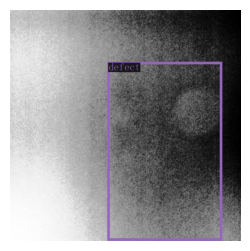

In [31]:
plt.figure(figsize=(3, 3))
plt.imshow(image.get_image())
plt.axis('off')
plt.show()